In [1]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh.plotting import *
from matmodlab2 import *
from numpy import *
import numpy as np
output_notebook()
import pandas as pd
import matplotlib.pyplot as plt

Setting up the Matmodlab notebook environment


Loading BokehJS ...

In [2]:
def run_model(B_in, load_dir, load_mags, frames=100):
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    mps1 = MaterialPointSimulator('uplastic-std')
    p = {'E': 10e6, 'Nu': .333, 'Y0': 10, 'H': 990, "B": B_in}
    mps1.material = ST_GPSR_TTM(**p)
    mps1.run_step(load_dir, load_mags, frames=frames)

    return  mps1.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY', 'EP_XX', 'EP_YY', 'EP_ZZ', 'EP_XY', 'EP_YZ', 'EP_XZ', 'EQPS']], mps1

def get_yield_point_princ(df, eqps=None):
    if eqps is None:
        y = df[df.EQPS > 1e-6].iloc[0]
    else:
        y = df[df.EQPS > eqps].iloc[0]
    # Build a stress tensor
    s11 = y['S.XX']
    s22 = y['S.YY']
    s33 = y['S.ZZ']
    s13 = y['S.XZ']
    s23 = y['S.YZ']
    s12 = y['S.XY']
    stress_yield = np.array( [ [ s11, s12, s13], [ s12, s22, s23 ], [ s13, s23, s33 ] ] )

    return np.array([s11, s22, s33])

angle_pairs = []
for deg in np.linspace(0,2*np.pi,15):
    N = 0.01
    SH = 0.01 #np.sqrt(3)*1e3
    x = N*np.cos(deg)
    y = SH*np.sin(deg)
    angle_pairs.append([x,y])
#print(angle_pairs)
pstress = []
phardstress = []
for angs in angle_pairs:
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    #B = array( [ [ -0.225, 0.39, 0.23], [-0.093, 0.41, 0.075], [ -0.258, 0.512, 0.139] ])*5.298
    def B(X_0):
        # B_in = (((X_0) * (array([[ 0.81968621,  0.15023522, -1.55706948],
        #     [ 0.15023522,  0.69435879, -0.85985827],
        #     [-1.55706948, -0.85985827, -2.8064723 ]]))) @ (array([[ -6.42754644,  -7.01260717,  14.00614571],
        #     [ -7.01260717,  31.60106974, -16.53910675],
        #     [ 14.00614571, -16.53910675,  -1.15540388]]) + (X_0) * (array([[ 0.81968621,  0.15023522, -1.55706948],
        #     [ 0.15023522,  0.69435879, -0.85985827],
        #     [-1.55706948, -0.85985827, -2.8064723 ]]))) + array([[ 0.22331365, -0.51818208,  0.23205657],
        #     [-0.51818208,  0.19680973,  0.19635221],
        #     [ 0.23205657,  0.19635221,  0.32496223]])) @ (((X_0) * (array([[ 0.81968621,  0.15023522, -1.55706948],
        #     [ 0.15023522,  0.69435879, -0.85985827],
        #     [-1.55706948, -0.85985827, -2.8064723 ]]))) @ (array([[ -6.42754644,  -7.01260717,  14.00614571],
        #     [ -7.01260717,  31.60106974, -16.53910675],
        #     [ 14.00614571, -16.53910675,  -1.15540388]]) + (X_0) * (array([[ 0.81968621,  0.15023522, -1.55706948],
        #     [ 0.15023522,  0.69435879, -0.85985827],
        #     [-1.55706948, -0.85985827, -2.8064723 ]]))) + array([[ 0.22331365, -0.51818208,  0.23205657],
        #     [-0.51818208,  0.19680973,  0.19635221],
        #     [ 0.23205657,  0.19635221,  0.32496223]]))
        # B_in = np.linalg.inv(B_in)
        B_in = np.eye(3)
        return B_in
    stress, mps = run_model(B, 'EESSSS', (angs[0], angs[1], 0, 0 ,0,0))

    prin_stress = get_yield_point_princ(stress)
    pstress.append(prin_stress)
    prin_stress_hard = get_yield_point_princ(stress, eqps=2.631578947368420907e-02)
    phardstress.append(prin_stress_hard)



In [ ]:
# Plot the actualy data
# load data
data = np.loadtxt("\\\\wsl.localhost\\Ubuntu\\home\\brian\\st-bingo\\research\\data\\processed_data\\hill_w_hardening.txt")
nan_rows = np.all(np.isnan(data), axis=1)
n_yield_surfaces = np.argmax(nan_rows)
data = data[np.invert(nan_rows)]

print("n of yield surfaces:", n_yield_surfaces)
yield_points_3d = data[:, :3]
all_eps = data[:, 3][:, None, None]


n of yield surfaces: 10


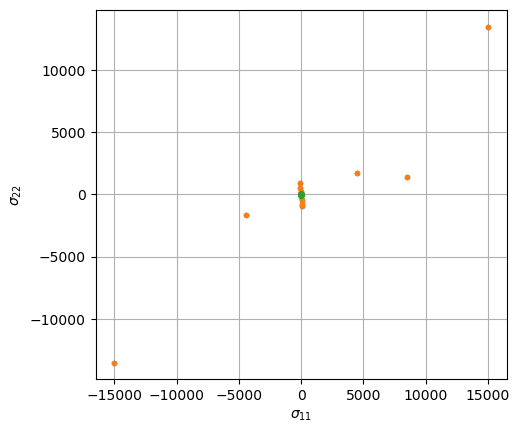

In [ ]:
pstress = np.array(pstress)
phardstress = np.array(phardstress)
plt.plot(pstress[:,0], pstress[:,1], '.')
plt.plot(phardstress[:,0], phardstress[:,1], '.')
plt.xlabel('$\\sigma_{11}$')
plt.ylabel('$\\sigma_{22}$')

plt.plot(yield_points_3d[:,0], yield_points_3d[:,1], '.')

plt.grid()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')